## **3D PLOT FOM-ROM @ FINAL TIME and for $\boldsymbol{\mu}_{reference}$**

In [1]:
# Pulizia
from IPython import get_ipython
get_ipython().magic('clear')
get_ipython().magic('reset -f')

# Import libraries:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.sparse as sparse
import h5py
import sys
import os

# Import user-defined libraries:
from FreeFEM import FFmatrix_fread, FFvector_fread

/var/folders/gs/p2p59ns16hlgpqv_027665gm0000gn/T/ipykernel_3259/3689771914.py:3: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('clear')
/var/folders/gs/p2p59ns16hlgpqv_027665gm0000gn/T/ipykernel_3259/3689771914.py:4: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('reset -f')


In [2]:
# Load coordinates:
coordinates_Px = FFvector_fread('mesh_utilities/vv_cc_Px.btxt')
coordinates_Pq = FFvector_fread('mesh_utilities/vv_cc_Pq.btxt')

# Identify degrees of freedom of the Px and Pq spaces:
sFO_Px = coordinates_Px.shape[0]
sFO_Pq = coordinates_Pq.shape[0]
print(rf'Degree of freedom = {sFO_Px}')

# Define vector of all Px indeces:
mask_all = np.arange(sFO_Px, dtype=int)

# Identify indeces of the top, bottom and middle boundaries in Px:
mask_inf_bc = mask_all[np.isclose([coordinates_Px[ii, 1] for ii in range(sFO_Px)], np.zeros((sFO_Px)))]
mask_sup_bc = mask_all[np.isclose([coordinates_Px[ii, 1] for ii in range(sFO_Px)], np.ones((sFO_Px)))]
mask_mid_bc = mask_all[np.isclose([coordinates_Px[ii, 0] for ii in range(sFO_Px)], np.zeros((sFO_Px)))]
mask_ext_bc = mask_all[np.isclose([coordinates_Px[ii, 0] for ii in range(sFO_Px)], np.ones((sFO_Px)))]

# Identify indeces of the Dirichlet b.c. for the temperature and concentration field:
mask_bc_T = np.fromiter(set(mask_sup_bc), int)
mask_bc_C = np.fromiter(set(mask_sup_bc) | set(mask_ext_bc) | set(mask_inf_bc), int)

# Identify indeces of the interior for the temperature and concentration field:
mask_in_T = [ii for ii in mask_all if ii not in mask_bc_T]
mask_in_C = [ii for ii in mask_all if ii not in mask_bc_C]



#caso 3D avevo: inte_C = mass_Px.dot(np.ones((sFO_Px))) / volume                   #ho tolto [mask_in_C]

Degree of freedom = 10201


In [3]:
# Import mass matrices on the Px and on the Pq space:
mass_Px = FFmatrix_fread('mesh_utilities/ww_mm_Px.btxt')
mass_Pq = FFmatrix_fread('mesh_utilities/ww_mm_Pq.btxt')
mass_Pm = FFmatrix_fread('mesh_utilities/ww_uu_Px_Pq.btxt')

# Extract integration weights and diagonal matrix with their inverse:
weights_Pq = mass_Pq.diagonal()
project_Pq = sparse.diags(np.reciprocal(weights_Pq))

# Import map from Px to Pq and to the dx, dy, dz derivative evaluated in Pq:
PxtoPquu_C = project_Pq.dot(FFmatrix_fread('mesh_utilities/ww_uu_Px_Pq.btxt')[:, mask_in_C])
PxtoPqdx_C = project_Pq.dot(FFmatrix_fread('mesh_utilities/ww_dx_Px_Pq.btxt')[:, mask_in_C])
PxtoPqdy_C = project_Pq.dot(FFmatrix_fread('mesh_utilities/ww_dy_Px_Pq.btxt')[:, mask_in_C])

# Define weights for the integration in polar coordinates:
polar_weights_Pq = np.multiply(coordinates_Pq[:, 0], weights_Pq)

# Compute volume of the domain:
volume = np.dot(np.ones(sFO_Pq), polar_weights_Pq)

# Assemble mass matrix and projected forcing term:
forc_C = PxtoPquu_C.T.dot(polar_weights_Pq[:, None])
mass_C = PxtoPquu_C.T.dot(PxtoPquu_C.multiply(polar_weights_Pq[:, None]))
inte_C = PxtoPquu_C.T.dot(polar_weights_Pq) / volume

### FOM SOLUTION

In [4]:
sol_new_C = np.loadtxt('data/Fullorder_Cfield.csv', delimiter=',')
print(inte_C @ sol_new_C[mask_in_C,-1])
#print(mass_Px.dot(sol_new_C[:, -1]).dot(np.ones((sFO_Px, 1)))[0] / volume)


1.6440810801954723e+24


### ROM SOLUTION

In [5]:
# Apri il file in modalità lettura
with h5py.File('matrici_RB.h5', 'r') as hf:
    # Accedi ai dataset e ricrea le matrici
    MM_RB = hf['MM_RB'][:]
    FF_RB = hf['FF_RB'][:]
    KK_RB = hf['KK_RB'][:]
    AA_RB = hf['AA_RB'][:]
    ZZ_CO = hf['ZZ_CO'][:]
    II_CO = hf['II_CO'][:]
    basis = hf['basis'][:]
print(basis.shape)

n_dofs = coordinates_Px.shape[0]
n_cols = basis.shape[1]
basis_extended = np.zeros((n_dofs, n_cols))
basis_extended[mask_in_C, :] = basis
print(basis_extended.shape)

#reconstructed = np.loadtxt('data/Reconstructed_field_reference.csv', delimiter=',')

(9900, 101)
(10201, 101)


In [6]:
# Define universal constants:
FISSION_ENERGY = 3.215E-11                      #[J/fissions]

# Define geometrical parameters:
RADIUS = 1e-05
LENGTH = 1e-03

# Define sources intensity:
FISSION_RATE = 3e19
FISSION_YIELD = 0.24E+00                
FUEL_THERMAL_CONDUCTIVITY = 2.208                                      #[W/(m K)]
SOURCE_C = FISSION_RATE * FISSION_YIELD         #[atm / (m^3 s)]
GAMMA_T = (FISSION_RATE * FISSION_ENERGY * LENGTH**2)/(FUEL_THERMAL_CONDUCTIVITY)

T_BC = 2000

TIME_DELTA = 10000

In [7]:
TT = T_BC + GAMMA_T * (1 - ZZ_CO**2) / 2

#SCIANTIX userà il modello scelto dall'utente 
WW = 7.60E-10 * np.exp(- 4.86E-19 / (TT * 1.380649E-23)) +\
     5.64E-25 * np.exp(- 1.91E-19 / (TT * 1.380649E-23)) * np.sqrt(FISSION_RATE) +\
     8.00E-40 * FISSION_RATE
 
CC_CO = np.hstack((II_CO @ WW / RADIUS**2, II_CO @ WW / LENGTH**2))
 
SS_RB = np.tensordot(CC_CO, KK_RB, axes=[0, 0])
QQ_RB = SOURCE_C * FF_RB
 
LHS_RB_static = MM_RB + TIME_DELTA * SS_RB #matrice + matrice * scalare. Avendo il termine MM_RB al lhs è forward euler, se invece fosse nel RHS sarebbe Backward. 
RHS_RB_static = TIME_DELTA * QQ_RB         #vettore per scalare

In [8]:
old_sol_RB = np.zeros((MM_RB.shape[0], 1))
reconstructed_solution = np.zeros((1000))
for ii in range(1000):
    old_sol_RB = np.linalg.solve(LHS_RB_static, RHS_RB_static + MM_RB.dot(old_sol_RB))
    value = np.dot(AA_RB, old_sol_RB)[0]
    reconstructed_solution[ii] = value
    print(reconstructed_solution[ii])

reconstructed_field = np.dot(basis_extended, old_sol_RB[:,0])
print(reconstructed_field.shape)
np.savetxt('data/Reconstructed_field_reference.csv', reconstructed_field, delimiter=',', fmt='%d')

6.0782442382943265e+22
1.1626512604621452e+23
1.6790521126426554e+23
2.164345907355522e+23
2.6231234469903515e+23
3.0586115119879845e+23
3.4732405844254024e+23
3.868929012265028e+23
4.2472431821647396e+23
4.6094955298123485e+23
4.956808263576691e+23
5.2901567870511604e+23
5.610400413408476e+23
5.9183047575142094e+23
6.214558471895843e+23
6.499786018413257e+23
6.774557589218433e+23
7.039396933185116e+23
7.29478761512851e+23
7.541178083978325e+23
7.778985823491667e+23
8.008600787816025e+23
8.230388273654452e+23
8.444691344273622e+23
8.651832893816546e+23
8.852117420472886e+23
9.045832562085815e+23
9.233250436395948e+23
9.414628819398758e+23
9.590212188550727e+23
9.76023265231245e+23
9.924910783407119e+23
1.0084456369934843e+24
1.0239069095917265e+24
1.0388939160803983e+24
1.0534247845836015e+24
1.0675168033846067e+24
1.081186468801174e+24
1.0944495294213789e+24
1.1073210270946485e+24
1.1198153350149362e+24
1.1319461931852671e+24
1.1437267415134766e+24
1.1551695507560963e+24
1.16628665149

In [9]:
FOM = sol_new_C[:, -1]
ROM = reconstructed_field 
print(FOM.shape)
print(ROM.shape)

FOM_ROM = np.abs(FOM - ROM)
print(np.max(FOM_ROM))
print(FOM_ROM.shape)

FOM_ROM = np.abs(FOM - ROM)/np.max(np.abs(FOM))
print(np.max(FOM_ROM))

(10201,)
(10201,)
1.4730084276180177e+23
(10201,)
0.01791812712162273


In [13]:
ABS_ERR = np.linalg.norm(FOM - ROM, axis=0) 
REL_ERR = ABS_ERR / np.linalg.norm(sol_new_C[:, -1], axis=0)
print(REL_ERR)

0.0017720146594933867


In [ ]:
#FOM_ROM = np.abs(sol_new_C[:, -1] - ROM[:,0])
#/sol_new_C[mask_in_C, -1])*100

#FOM-ROM = np.abs(sol_new_C[:, -1] - ROM[:,0]) / np.max(np.abs(sol_new_C[:,-1]))

#FOM_ROM = np.abs(sol_new_C[:, -1] - ROM[:,0])/sol_new_C[:, -1]
#print(np.max(FOM_ROM))
#print(FOM_ROM.shape)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

0.01791812712162273


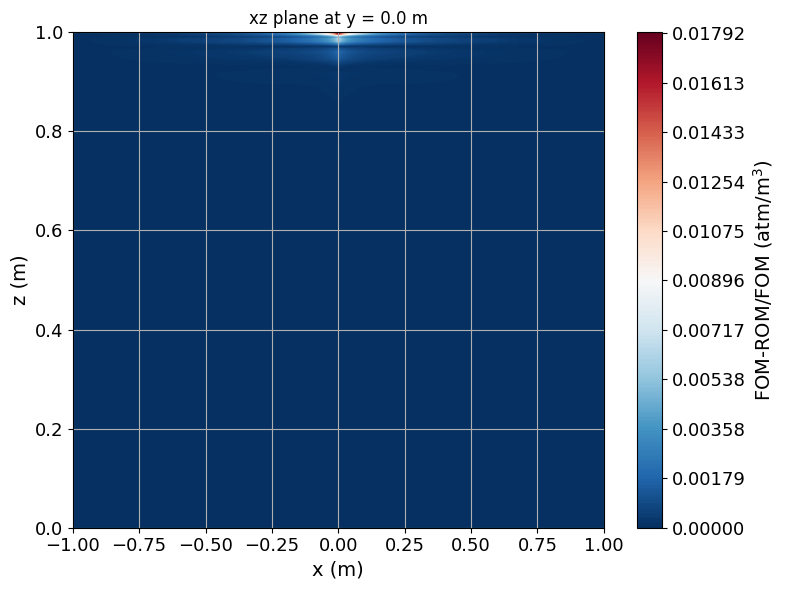

In [19]:
field = np.hstack((FOM_ROM, FOM_ROM))
coord_x = np.hstack((coordinates_Px[:, 0], - coordinates_Px[:, 0]))
coord_z = np.hstack((coordinates_Px[:, 1],   coordinates_Px[:, 1]))

max_tick = np.max(field)
tick_step = max_tick/10
print(max_tick)
ticks = np.linspace(0, max_tick, int(max_tick / tick_step) + 1)


plt.figure(figsize=(8, 6))
contour = plt.tricontourf(coord_x, coord_z, field, 400, cmap='RdBu_r', vmin=0, vmax = max_tick)
cbar = plt.colorbar(contour, ticks=ticks)       # Usa '%.2f' per due cifre decimali
cbar.ax.tick_params(labelsize=13)  # Dimensione del testo della colorbar
cbar.set_label('FOM-ROM/FOM (atm/m$^3$)', fontsize=14)

plt.title(f'xz plane at y = {0.00} m')
plt.tick_params(axis="y", labelsize=13)
plt.tick_params(axis='x', labelsize=13)
plt.xlabel('x (m)',fontsize=14)
plt.ylabel('z (m)',fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig('plot/FOM-ROM.pdf', bbox_inches='tight') 